In [1]:
from loracraft.metrics import *
import glob
import numpy as np 
import json
import wandb
from loracraft.api import log_images, query_runs, get_images_from_run
import matplotlib.pyplot as plt



In [2]:
with open('lora_db.json', 'r') as f:
    lora_db = json.load(f)

In [3]:
trigger_lora = {}
categories = []
for lora in lora_db:
    trigger_lora[lora_db[lora]['triggers'][0]] = [lora]
    if lora_db[lora]['category'] not in categories:
        categories.append(lora_db[lora]['category'])

In [4]:
categories

['Character', 'Style', 'Concept', 'Clothing', 'Buildings']

In [5]:
trigger_lora

{'BJ_Sewing_doll': ['SewingDoll'],
 'cinematicpainting': ['CinematicPainting'],
 'pixar style': ['PixarXL'],
 'ral-friedegg': ['FriedEgg'],
 'cyborg': ['FacelessCyborgs'],
 'drawix6': ['Drawing'],
 'airpods_max ': ['AirPodsMax'],
 'Isometric_Setting': ['Isometric'],
 'vintage_p_style': ['VintagePortrait'],
 'Costume ShoshiZohar': ['SillyCostume'],
 'symmetrical': ['Symmetrical'],
 'ral-feathercoat': ['Federkleid']}

In [6]:

prompts = []
with open ("all_configs_with_0_loras.json", 'r') as f:
    configs = json.load(f)

In [7]:
for config in configs:
   if config['prompts'] not in prompts:
       prompts.append(config['prompts'])

In [8]:
prompts

[['ral-feathercoat'],
 ['drawix6'],
 ['pixar style'],
 ['Costume ShoshiZohar'],
 ['cyborg'],
 ['cinematicpainting'],
 ['BJ_Sewing_doll'],
 ['symmetrical'],
 ['Isometric_Setting'],
 ['vintage_p_style'],
 ['ral-friedegg'],
 ['airpods_max ']]

In [9]:
wandb.login()


wandb: Currently logged in as: uzeyirmammad. Use `wandb login --relogin` to force relogin


True

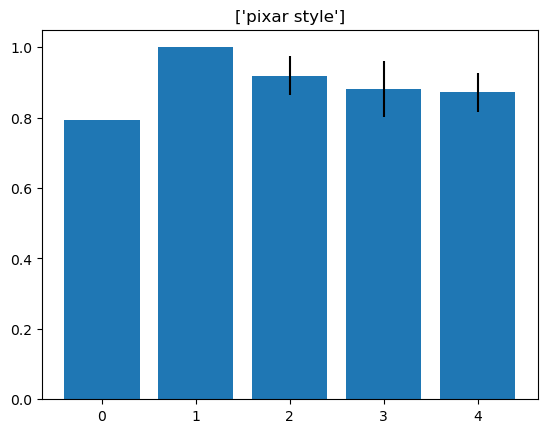

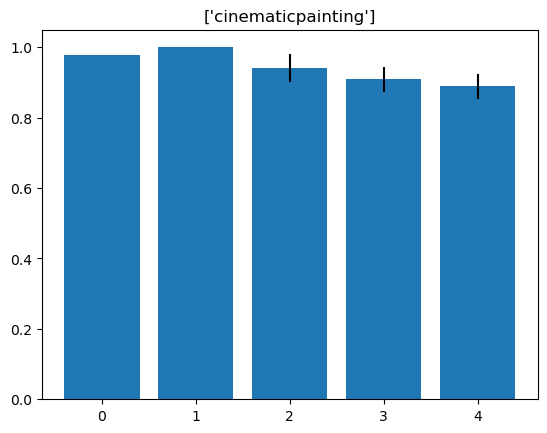

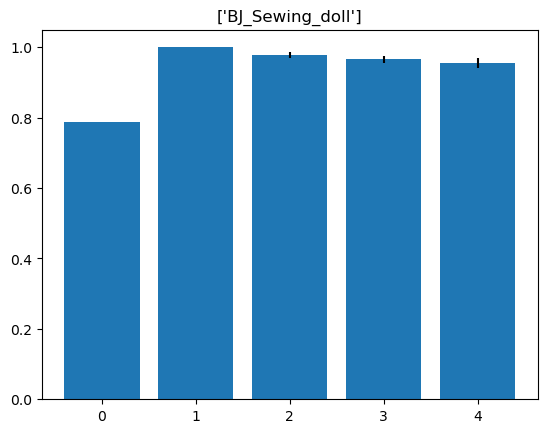

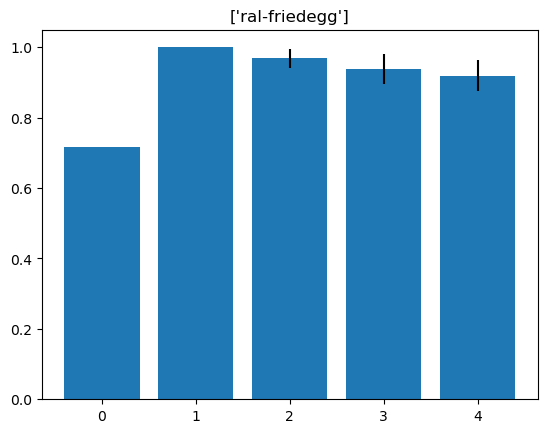

In [64]:

max_loras = 4
scores_all = np.zeros((len(prompts), max_loras+1))

k = 0


for prompt_index, prompt in enumerate(prompts):

    
    
    scores = {}
    for i in range(max_loras+1):
        scores[i] = []
    
    runs = query_runs({"prompts": prompt})
    imgs = [get_images_from_run(run)  for run in runs]
    configs = [run.config  for run in runs]

    imgs_ = []
    configs_ = []
    for index_config, config in enumerate(configs):
        if len(np.unique(config['loras'])) == len(config['loras']):
            imgs_.append(imgs[index_config])
            configs_.append(config)

    imgs = imgs_
    configs = configs_

    max_weights = 0
    for config in configs:
        max_weights = len(config['weights']) if len(config['weights']) > max_weights else max_weights

    if max_weights == max_loras:
        imgs_ = []
        configs_ = []
        for index, img in enumerate(imgs):
            if len(img):
                imgs_.append(img)
                configs_.append(configs[index])

        imgs = imgs_
        configs = configs_



        for index, config in enumerate(configs):
            if config['loras'] == trigger_lora[prompt[0]]:
                reference_index = index
                break

        for index, img in enumerate(imgs):
            k += 1

            clip = clip_score(imgs[reference_index], img)
            scores[len(configs[index]['loras'])].append(clip)


        avgs = []
        stds = []
        for i in range(max_loras+1):
            avgs.append(np.average(scores[i]))
            stds.append(np.std(scores[i]))

        scores_all[prompt_index] = avgs
        
        plt.bar(np.arange(max_loras+1), avgs, yerr = stds)
        plt.title(prompt)
        plt.show()
        plt.close()


<BarContainer object of 5 artists>

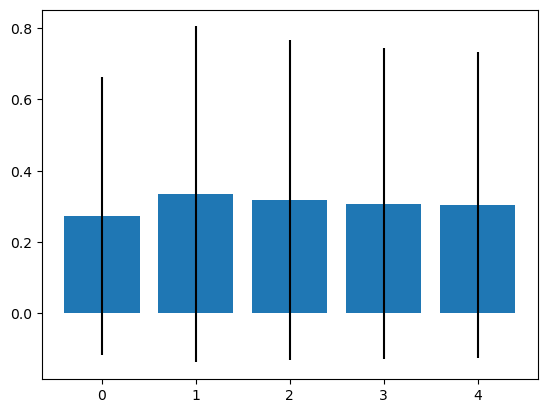

In [66]:
plt.bar(np.arange(5), 
        np.average(scores_all, axis = 0), 
        yerr = np.std(scores_all, axis =0))

(0.0, 1.1)

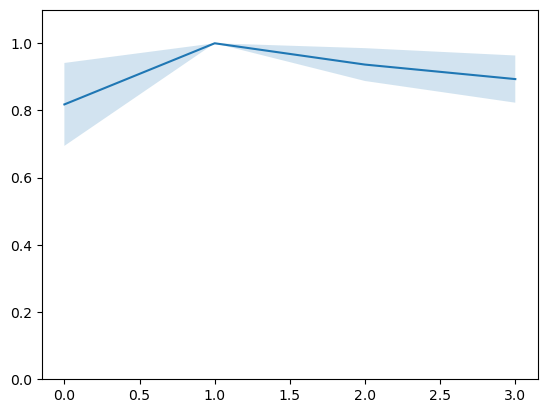

In [38]:
avgs_all = np.average(scores_all[1:], axis = 0)
stds_all = np.std(scores_all[1:], axis = 0)

plt.plot(np.arange(4), avgs_all)
plt.fill_between(np.arange(4), avgs_all+stds_all, avgs_all-stds_all, alpha = 0.2)
plt.ylim(0,1.1)

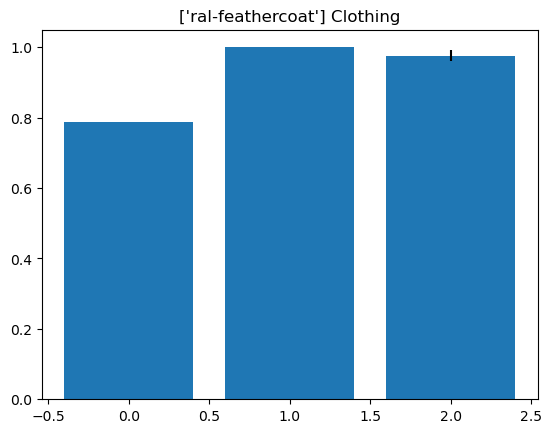

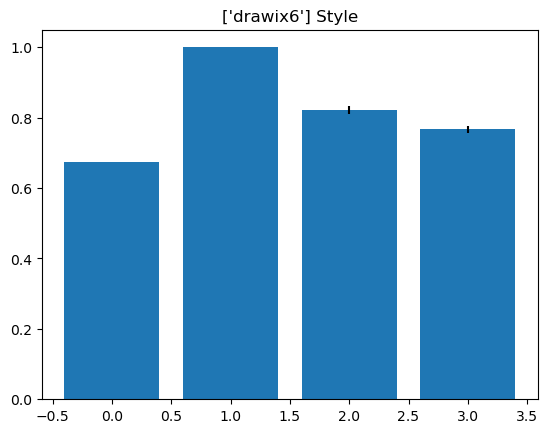

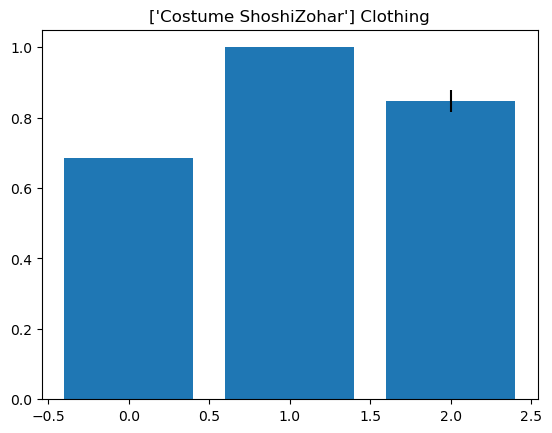

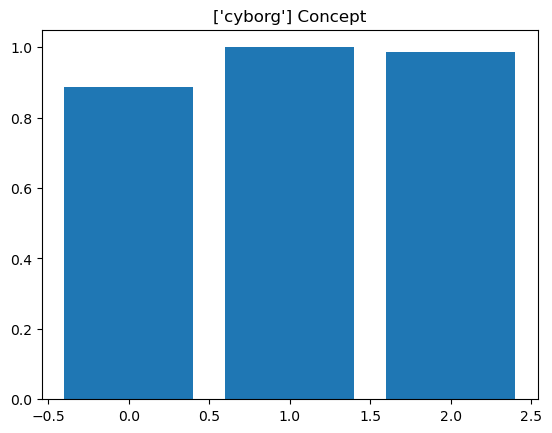

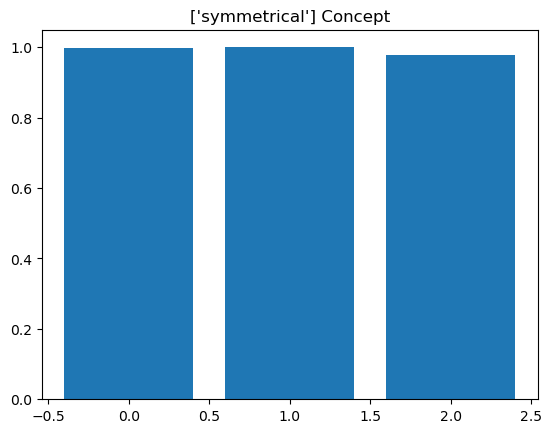

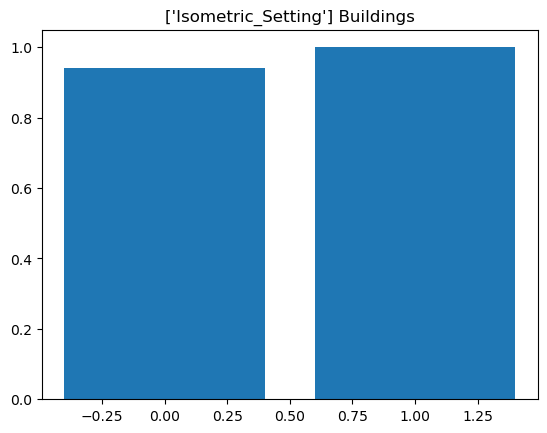

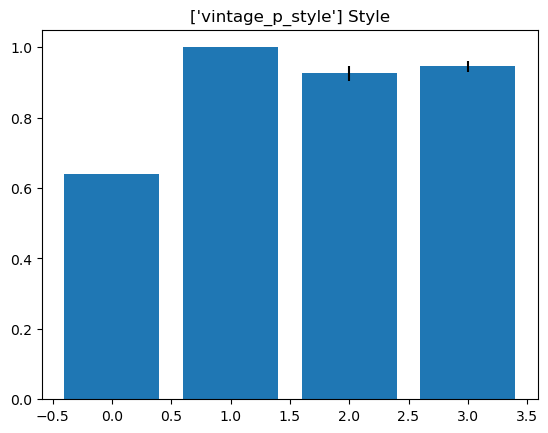

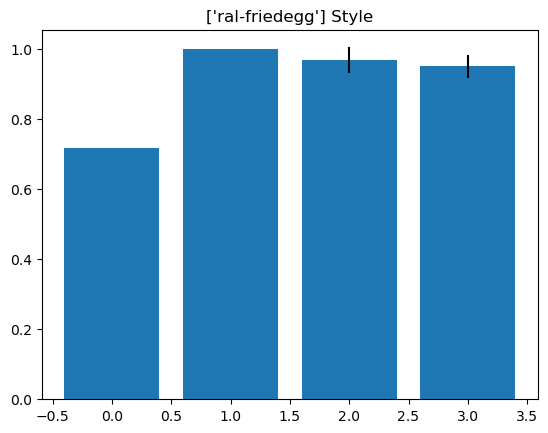

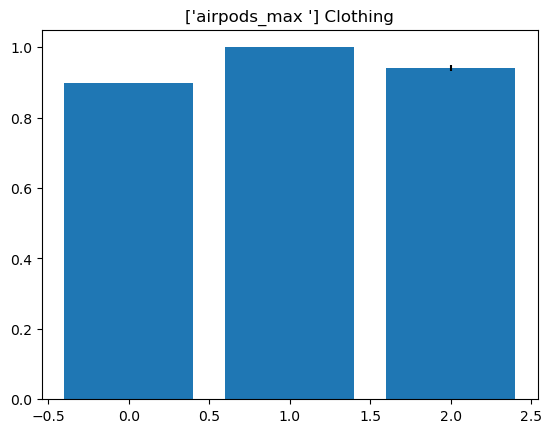

In [39]:



for prompt_index, prompt in enumerate(prompts):
    

    
    runs = query_runs({"prompts": prompt})
    imgs = [get_images_from_run(run)  for run in runs]
    configs = [run.config  for run in runs]


    for index, config in enumerate(configs):
        if config['loras'] == trigger_lora[prompt[0]]:
            reference_index = index
            break

    reference_img = imgs[reference_index]

    imgs_ = []
    configs_ = []

    for config_index, config in enumerate(configs):
        if len(config['loras']) == 0:     
            if len(imgs[config_index]):
                imgs_.append(imgs[config_index])
                configs_.append(config) 

        categories = []
        for lora in config['loras']:
            categories.append(lora_db[lora]['category'])
        if len(np.unique(categories)) == 1:
            category = categories[0]
            if len(imgs[config_index]):
                imgs_.append(imgs[config_index])
                configs_.append(config)


    imgs = imgs_ 
    configs = configs_

    imgs_ = []
    configs_ = []
    for index_config, config in enumerate(configs):
        if len(np.unique(config['loras'])) == len(config['loras']):
            imgs_.append(imgs[index_config])
            configs_.append(config)
   
    imgs = imgs_ 
    configs = configs_
    
    max_loras = 0
    for config in configs:
        if len(config['loras']) > max_loras: max_loras = len(config['loras'])
    
    scores = {}
    for i in range(max_loras+1):
        scores[i] = []



    if len(imgs) and len(reference_img):

        for index, img in enumerate(imgs):
            clip = clip_score(reference_img, img)
            scores[len(configs[index]['loras'])].append(clip)


        avgs = []
        stds = []
        for i in range(max_loras+1):
            avgs.append(np.average(scores[i]))
            stds.append(np.std(scores[i]))

        
        plt.bar(np.arange(max_loras+1), avgs, yerr = stds)
        plt.title(f'{prompt}' + f' {category}')
        plt.show()
        plt.close()


In [10]:
prompt_loras_score = []

for prompt_index, prompt in enumerate(prompts):

    print(prompt)

    runs = query_runs({"prompts": prompt})
    imgs = [get_images_from_run(run)  for run in runs]
    configs = [run.config  for run in runs]


    for index, config in enumerate(configs):
        if config['loras'] == trigger_lora[prompt[0]] and len(imgs[index]):
            reference_img = imgs[index]
            break 

    for index_config, config in enumerate(configs):
        if len(np.unique(config['loras'])) == 3:
            clip = clip_score(reference_img, imgs[index_config])
            prompt_loras_score.append([prompt, config['loras'], clip])

    

['ral-feathercoat']
['drawix6']
['pixar style']
['Costume ShoshiZohar']
['cyborg']
['cinematicpainting']
['BJ_Sewing_doll']
['symmetrical']
['Isometric_Setting']
['vintage_p_style']
['ral-friedegg']
['airpods_max ']


In [11]:
indices_prompt_loras_score = np.arange(len(prompt_loras_score))
scores = []
for item in prompt_loras_score:
    scores.append(item[-1])

indices_prompt_loras_score = np.argsort(scores)
            

In [12]:
for index in indices_prompt_loras_score:
    print(prompt_loras_score[index])

[['Isometric_Setting'], ['Isometric', 'SillyCostume', 'Federkleid'], 0.47244271636009216]
[['pixar style'], ['PixarXL', 'SillyCostume', 'Federkleid'], 0.4899056553840637]
[['vintage_p_style'], ['VintagePortrait', 'SillyCostume', 'Federkleid'], 0.5095301866531372]
[['drawix6'], ['Drawing', 'SillyCostume', 'Federkleid'], 0.544600248336792]
[['vintage_p_style'], ['VintagePortrait', 'CinematicPainting', 'Federkleid'], 0.6123684644699097]
[['drawix6'], ['Drawing', 'CinematicPainting', 'SillyCostume'], 0.6215100884437561]
[['airpods_max '], ['AirPodsMax', 'Details', 'FacelessCyborgs'], 0.6427798271179199]
[['drawix6'], ['Drawing', 'VintagePortrait', 'SillyCostume'], 0.6458741426467896]
[['drawix6'], ['Drawing', 'FriedEgg', 'AirPodsMax'], 0.6507223844528198]
[['Costume ShoshiZohar'], ['SillyCostume', 'FriedEgg', 'FacelessCyborgs'], 0.6734002232551575]
[['Costume ShoshiZohar'], ['SillyCostume', 'Drawing', 'Isometric'], 0.6835249066352844]
[['Costume ShoshiZohar'], ['SillyCostume', 'CinematicPa

In [13]:
prompt_loras_score

[[['ral-feathercoat'],
  ['Federkleid', 'Isometric', 'Symmetrical'],
  0.9318639039993286],
 [['ral-feathercoat'],
  ['Federkleid', 'AirPodsMax', 'Symmetrical'],
  0.9451841115951538],
 [['ral-feathercoat'],
  ['Federkleid', 'Drawing', 'Isometric'],
  0.978309690952301],
 [['ral-feathercoat'],
  ['Federkleid', 'FacelessCyborgs', 'SillyCostume'],
  0.9269497394561768],
 [['ral-feathercoat'],
  ['Federkleid', 'FacelessCyborgs', 'Drawing'],
  0.9461163282394409],
 [['ral-feathercoat'],
  ['Federkleid', 'Details', 'VintagePortrait'],
  0.9530845284461975],
 [['ral-feathercoat'],
  ['Federkleid', 'Details', 'FacelessCyborgs'],
  0.9346948862075806],
 [['ral-feathercoat'],
  ['Federkleid', 'FriedEgg', 'VintagePortrait'],
  0.9382950067520142],
 [['ral-feathercoat'],
  ['Federkleid', 'FriedEgg', 'FacelessCyborgs'],
  0.8930959105491638],
 [['ral-feathercoat'],
  ['Federkleid', 'PixarXL', 'SillyCostume'],
  0.8329958915710449],
 [['ral-feathercoat'],
  ['Federkleid', 'PixarXL', 'Drawing'],
  0

In [68]:
import pandas as pd 

In [70]:
df = pd.DataFrame(prompt_loras_score)

In [71]:
df.to_csv('prompts_loras_score.csv')

In [16]:
print(prompt_loras_score[1])

AirPodsMax


In [22]:
lora_to_category = {lora: info['category'] for lora, info in lora_db.items()}
def all_equal(lst):
    return lst.count(lst[0]) == len(lst)
    
same_category = []
different_category = []

for item in prompt_loras_score:
    loras = item[1]
    categories = [lora_to_category.get(lora, None) for lora in loras]
    
    if None in categories:
        continue
    
    if all_equal(categories):
        same_category.append(item)
    else:
        if len(set(categories)) == len(loras):
            different_category.append(item)

In [20]:
same_category

[[['drawix6'],
  ['Drawing', 'CinematicPainting', 'PixarXL'],
  0.7776739597320557],
 [['pixar style'],
  ['PixarXL', 'FriedEgg', 'VintagePortrait'],
  0.8558062314987183],
 [['pixar style'],
  ['PixarXL', 'CinematicPainting', 'FriedEgg'],
  0.85282301902771],
 [['pixar style'],
  ['PixarXL', 'CinematicPainting', 'Drawing'],
  0.9087372422218323],
 [['cinematicpainting'],
  ['CinematicPainting', 'FriedEgg', 'VintagePortrait'],
  0.8930912613868713],
 [['cinematicpainting'],
  ['CinematicPainting', 'PixarXL', 'FriedEgg'],
  0.9264459609985352],
 [['cinematicpainting'],
  ['CinematicPainting', 'FriedEgg', 'VintagePortrait'],
  0.9147626161575317],
 [['cinematicpainting'],
  ['CinematicPainting', 'PixarXL', 'Drawing'],
  0.9097684621810913],
 [['vintage_p_style'],
  ['VintagePortrait', 'PixarXL', 'Drawing'],
  0.9296524524688721],
 [['ral-friedegg'],
  ['FriedEgg', 'CinematicPainting', 'Drawing'],
  0.8638905882835388],
 [['ral-friedegg'],
  ['FriedEgg', 'CinematicPainting', 'PixarXL'],
 

In [21]:
different_category

[[['ral-feathercoat'],
  ['Federkleid', 'Isometric', 'Symmetrical'],
  0.9318639039993286],
 [['ral-feathercoat'],
  ['Federkleid', 'Drawing', 'Isometric'],
  0.978309690952301],
 [['ral-feathercoat'],
  ['Federkleid', 'FacelessCyborgs', 'Drawing'],
  0.9461163282394409],
 [['ral-feathercoat'],
  ['Federkleid', 'FriedEgg', 'FacelessCyborgs'],
  0.8930959105491638],
 [['ral-feathercoat'],
  ['Federkleid', 'CinematicPainting', 'Isometric'],
  0.9423230290412903],
 [['drawix6'],
  ['Drawing', 'FacelessCyborgs', 'Federkleid'],
  0.8094944357872009],
 [['drawix6'],
  ['Drawing', 'FacelessCyborgs', 'Isometric'],
  0.7748650312423706],
 [['pixar style'], ['PixarXL', 'Isometric', 'Symmetrical'], 0.951688289642334],
 [['pixar style'],
  ['PixarXL', 'AirPodsMax', 'Symmetrical'],
  0.8594765663146973],
 [['pixar style'],
  ['PixarXL', 'FacelessCyborgs', 'SillyCostume'],
  0.9296817183494568],
 [['pixar style'],
  ['PixarXL', 'FacelessCyborgs', 'Isometric'],
  0.940784215927124],
 [['pixar style']

In [23]:
same_category.sort(key=lambda x: x[2], reverse=True)
different_category.sort(key=lambda x: x[2], reverse=True)

In [24]:
same_category

[[['ral-friedegg'], ['FriedEgg', 'PixarXL', 'Drawing'], 0.9857772588729858],
 [['vintage_p_style'],
  ['VintagePortrait', 'PixarXL', 'Drawing'],
  0.9296524524688721],
 [['cinematicpainting'],
  ['CinematicPainting', 'PixarXL', 'FriedEgg'],
  0.9264459609985352],
 [['ral-friedegg'],
  ['FriedEgg', 'CinematicPainting', 'PixarXL'],
  0.9218847155570984],
 [['cinematicpainting'],
  ['CinematicPainting', 'FriedEgg', 'VintagePortrait'],
  0.9147626161575317],
 [['cinematicpainting'],
  ['CinematicPainting', 'PixarXL', 'Drawing'],
  0.9097684621810913],
 [['pixar style'],
  ['PixarXL', 'CinematicPainting', 'Drawing'],
  0.9087372422218323],
 [['cinematicpainting'],
  ['CinematicPainting', 'FriedEgg', 'VintagePortrait'],
  0.8930912613868713],
 [['ral-friedegg'],
  ['FriedEgg', 'CinematicPainting', 'Drawing'],
  0.8638905882835388],
 [['pixar style'],
  ['PixarXL', 'FriedEgg', 'VintagePortrait'],
  0.8558062314987183],
 [['pixar style'],
  ['PixarXL', 'CinematicPainting', 'FriedEgg'],
  0.852

In [25]:
different_category

[[['symmetrical'],
  ['Symmetrical', 'Isometric', 'VintagePortrait'],
  0.994387686252594],
 [['symmetrical'],
  ['Symmetrical', 'AirPodsMax', 'VintagePortrait'],
  0.9876630902290344],
 [['ral-friedegg'],
  ['FriedEgg', 'AirPodsMax', 'Symmetrical'],
  0.9871981739997864],
 [['symmetrical'], ['Symmetrical', 'PixarXL', 'Isometric'], 0.986355185508728],
 [['BJ_Sewing_doll'],
  ['SewingDoll', 'Isometric', 'Symmetrical'],
  0.9862418174743652],
 [['symmetrical'],
  ['Symmetrical', 'FriedEgg', 'AirPodsMax'],
  0.983259916305542],
 [['BJ_Sewing_doll'],
  ['SewingDoll', 'AirPodsMax', 'Symmetrical'],
  0.9831175804138184],
 [['cyborg'],
  ['FacelessCyborgs', 'VintagePortrait', 'Federkleid'],
  0.9827557802200317],
 [['Isometric_Setting'],
  ['Isometric', 'Drawing', 'SillyCostume'],
  0.9817378520965576],
 [['ral-feathercoat'],
  ['Federkleid', 'Drawing', 'Isometric'],
  0.978309690952301],
 [['symmetrical'],
  ['Symmetrical', 'VintagePortrait', 'SillyCostume'],
  0.9761400818824768],
 [['BJ_Se

In [27]:
average_score_same = sum(score[2] for score in same_category) / len(same_category)
average_score_different = sum(score[2] for score in different_category) / len(different_category)

In [28]:
average_score_same

0.8950261473655701

In [29]:
average_score_different

0.9303970277964414

In [30]:
category_scores = [(lora_db[score_entry[1][0]]['category'], score_entry[2]) for score_entry in same_category]

In [31]:
category_scores

[('Style', 0.9857772588729858),
 ('Style', 0.9296524524688721),
 ('Style', 0.9264459609985352),
 ('Style', 0.9218847155570984),
 ('Style', 0.9147626161575317),
 ('Style', 0.9097684621810913),
 ('Style', 0.9087372422218323),
 ('Style', 0.8930912613868713),
 ('Style', 0.8638905882835388),
 ('Style', 0.8558062314987183),
 ('Style', 0.85282301902771),
 ('Style', 0.7776739597320557)]

In [33]:
from collections import defaultdict

category_combination_scores = defaultdict(list)

for score_entry in different_category:
    categories = tuple(sorted([lora_db[lora]['category'] for lora in score_entry[1]]))
    category_combination_scores[categories].append(score_entry[2])

average_scores_by_combination = {combination: sum(scores)/len(scores) for combination, scores in category_combination_scores.items()}

sorted_combinations = sorted(average_scores_by_combination.items(), key=lambda x: x[1], reverse=True)

In [34]:
sorted_combinations

[(('Character', 'Clothing', 'Concept'), 0.976958692073822),
 (('Buildings', 'Character', 'Concept'), 0.9767518043518066),
 (('Buildings', 'Character', 'Style'), 0.9691155850887299),
 (('Character', 'Clothing', 'Style'), 0.9608186227934701),
 (('Character', 'Concept', 'Style'), 0.9469197988510132),
 (('Buildings', 'Concept', 'Style'), 0.9390576511621476),
 (('Clothing', 'Concept', 'Style'), 0.9234216925574512),
 (('Buildings', 'Clothing', 'Style'), 0.9142864694197973),
 (('Buildings', 'Clothing', 'Concept'), 0.883736789226532)]

In [90]:
from PIL import Image

In [91]:
all_images = Image.open('../../../Downloads/all.png')

/Users/vini/miniforge3/envs/brainhack/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (122683392 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [93]:
all_images_np = np.array(all_images)

In [113]:
images_all_list = []
for i in range(all_images_np.shape[0]//512):
    images_all_list.append([])
    for j in range(all_images_np.shape[1]//512):
        images_all_list[-1].append(all_images_np[i*512:(i+1)*512, j*512:(j+1)*512])

In [116]:
all_images = np.array(images_all_list)

In [126]:
all_images.shape

(36, 13, 512, 512, 3)

In [128]:
scores = np.zeros((all_images.shape[0], all_images.shape[1]))
for prompt in range(all_images.shape[0]):
    for number_of_loras in range(all_images.shape[1]):
        print(prompt, number_of_loras)
        clip = clip_score([all_images[prompt][1]],[all_images[prompt][number_of_loras]])
        scores[prompt, number_of_loras] = clip



0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16

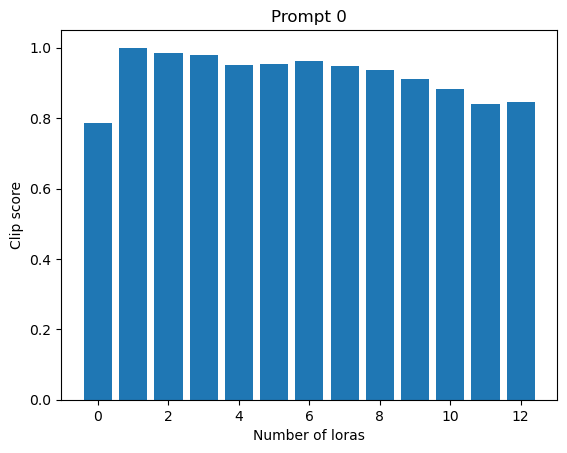

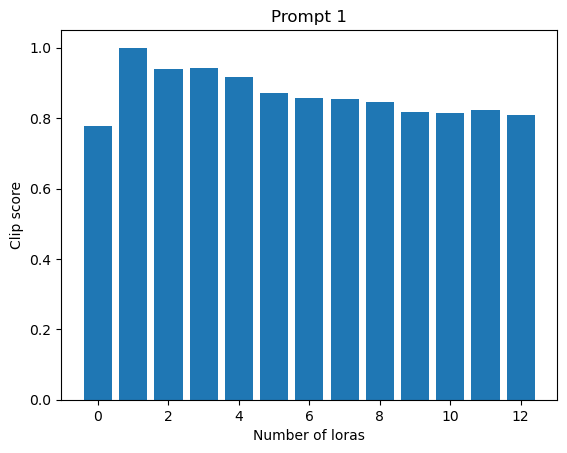

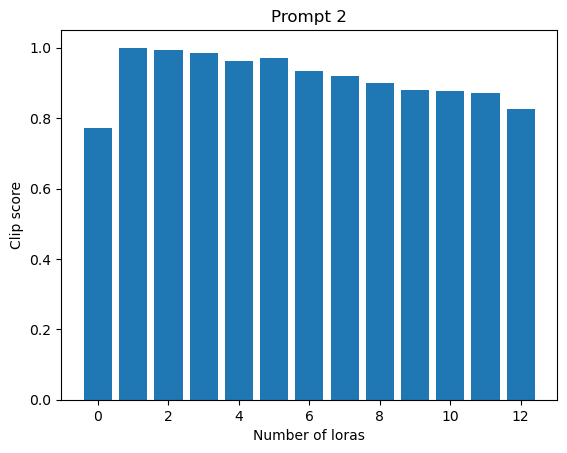

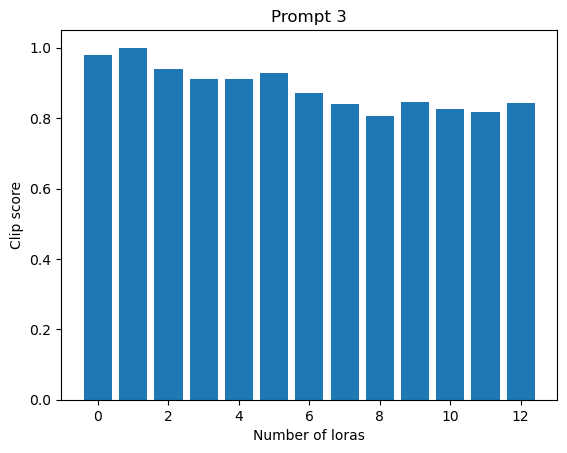

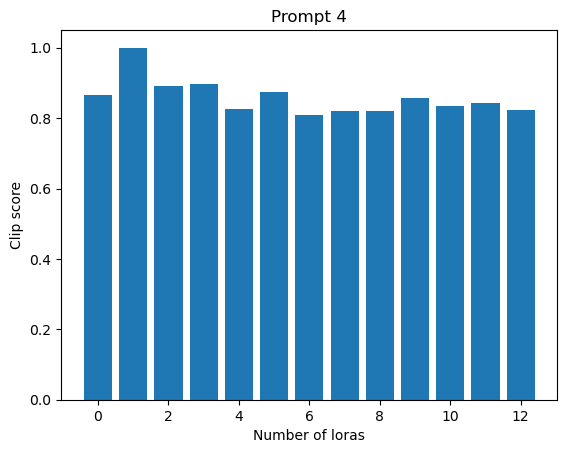

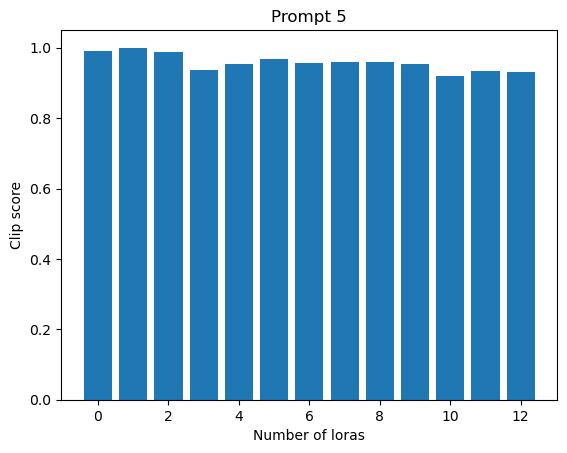

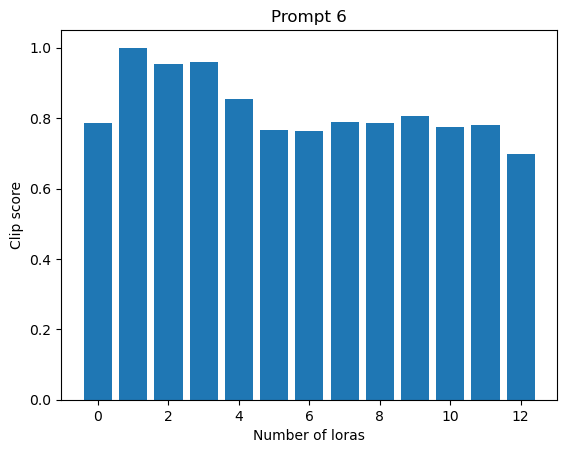

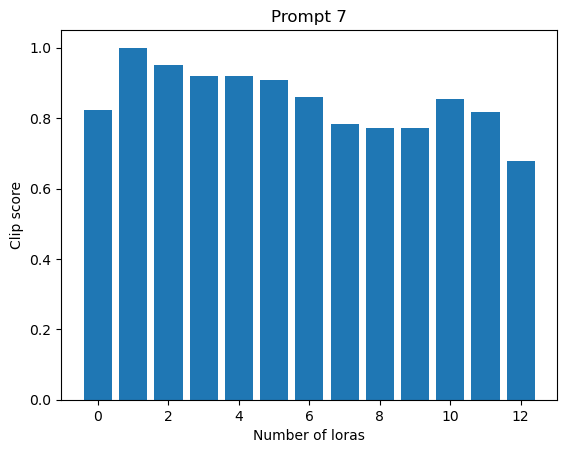

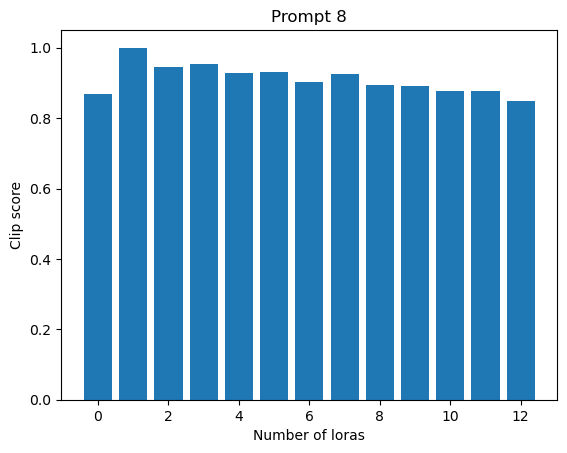

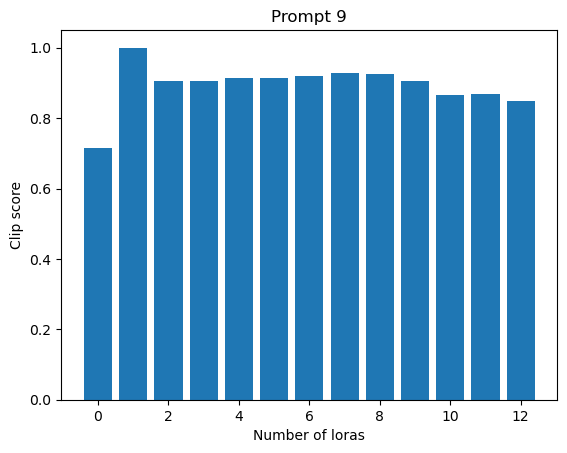

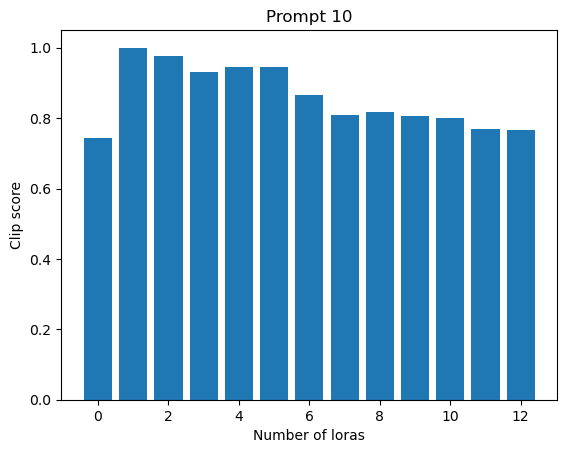

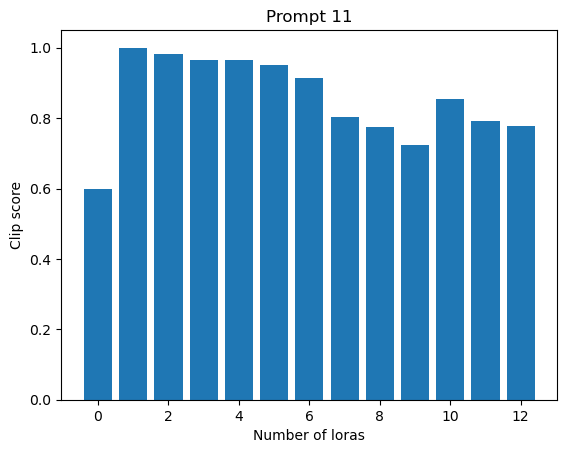

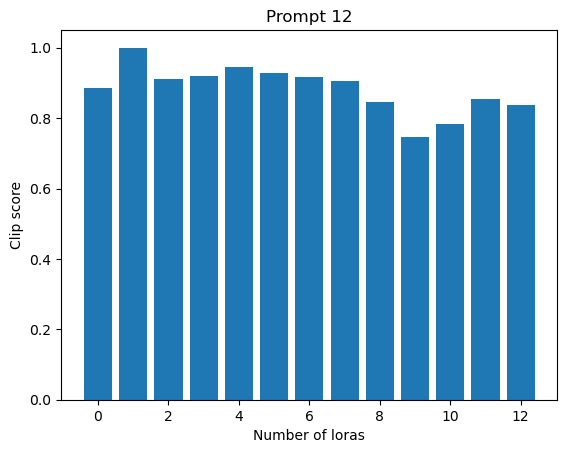

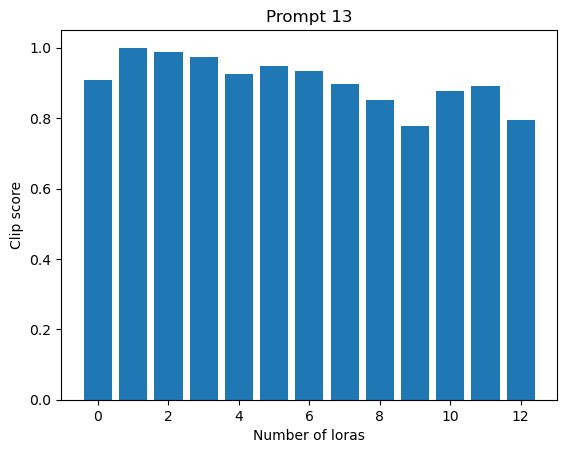

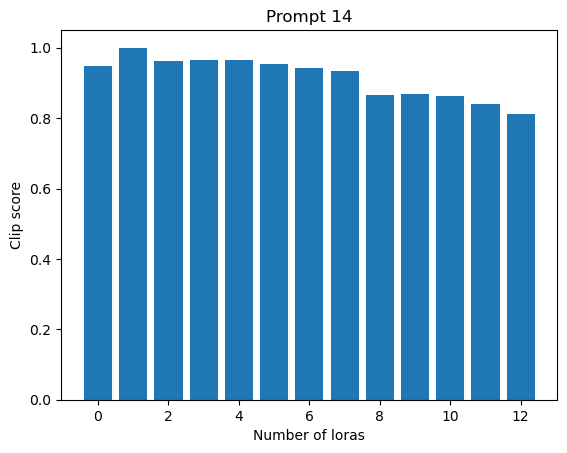

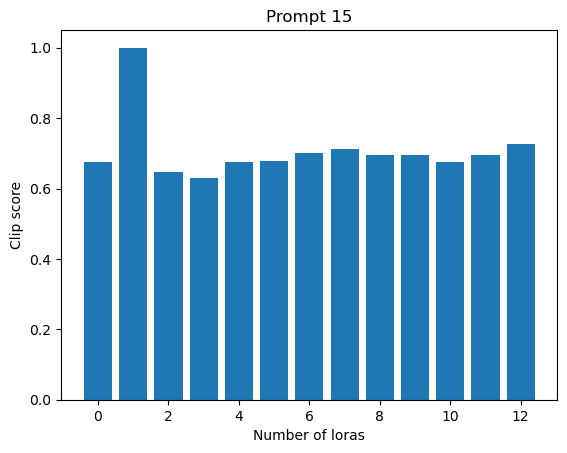

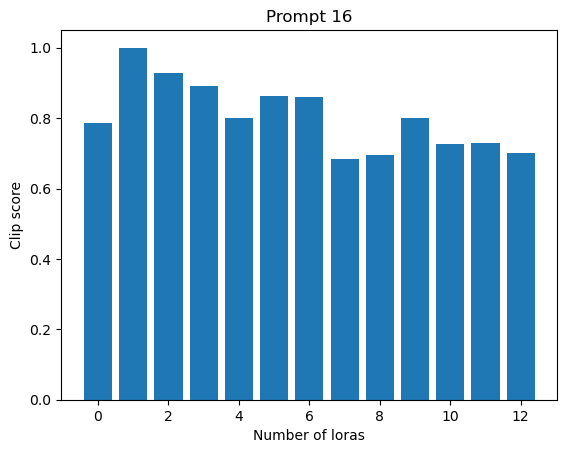

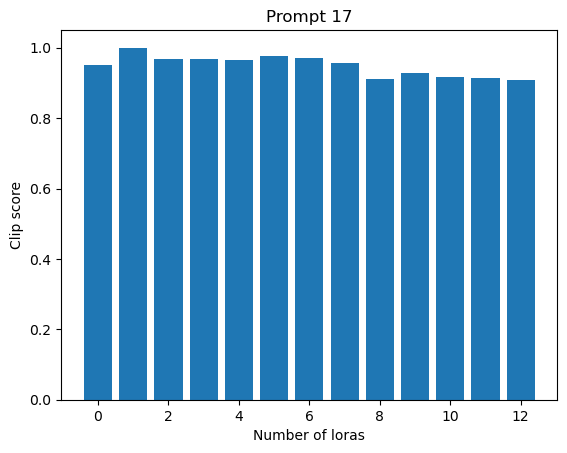

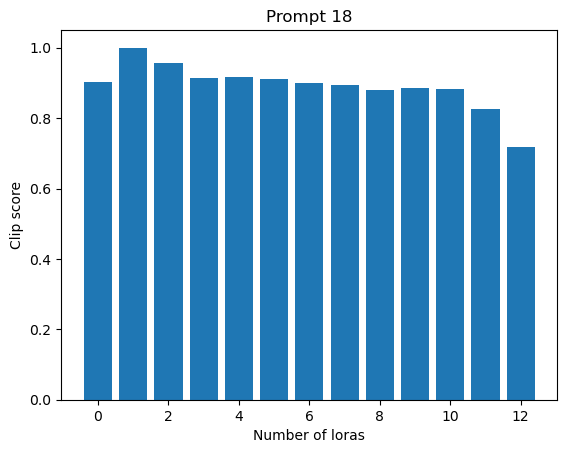

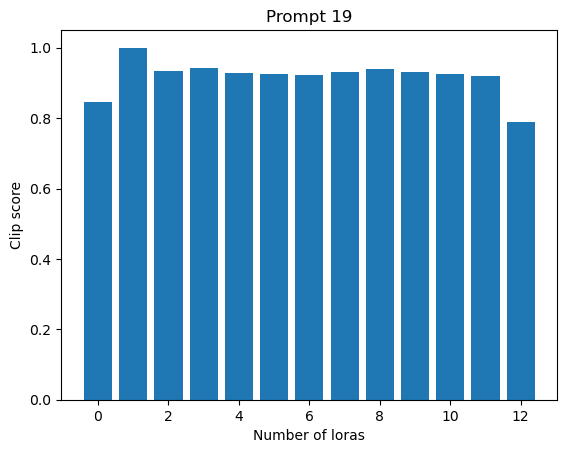

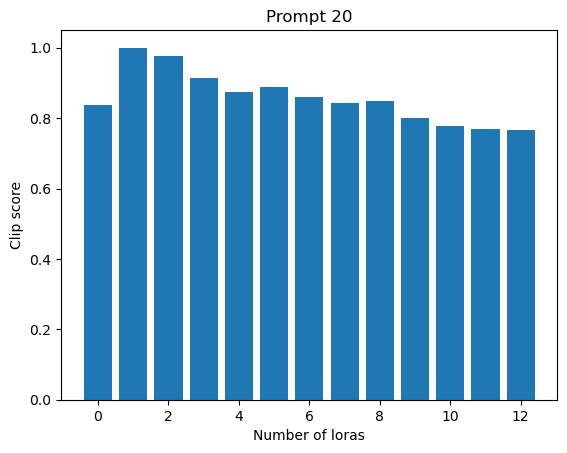

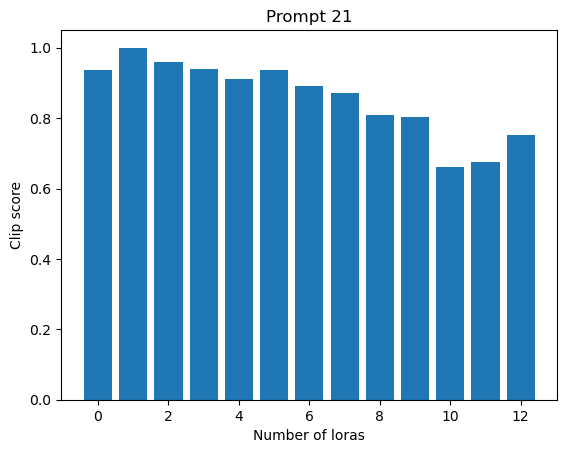

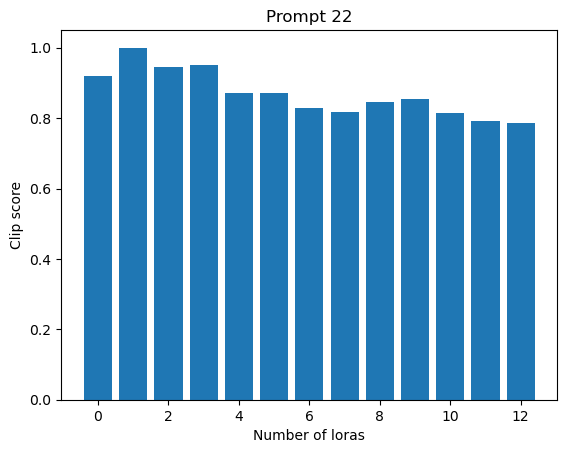

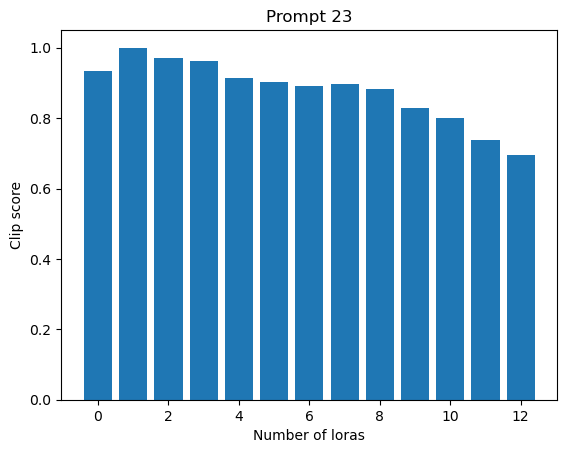

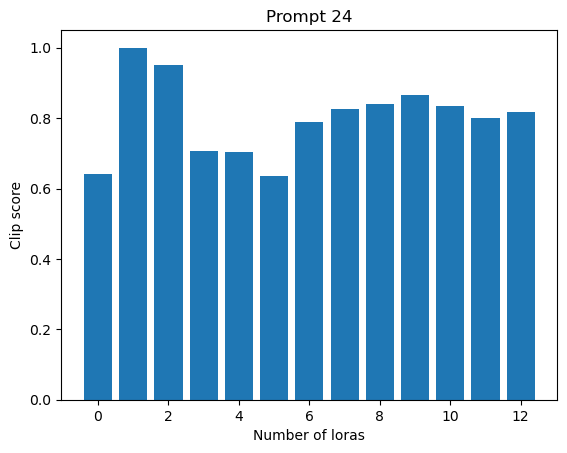

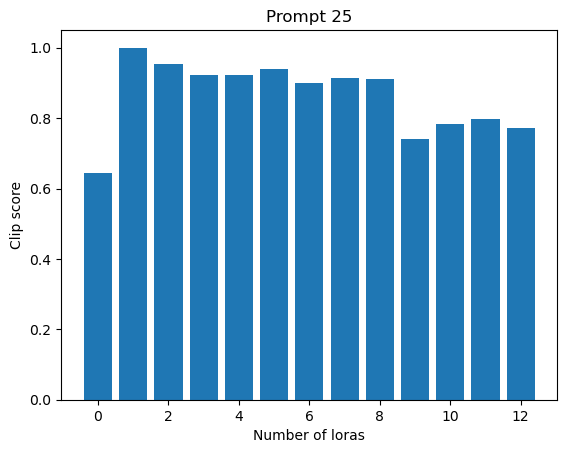

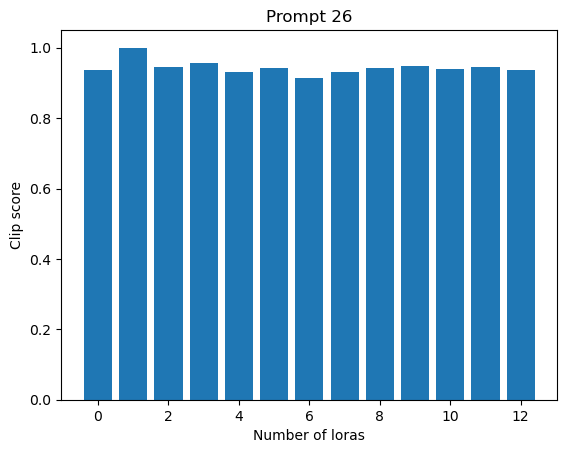

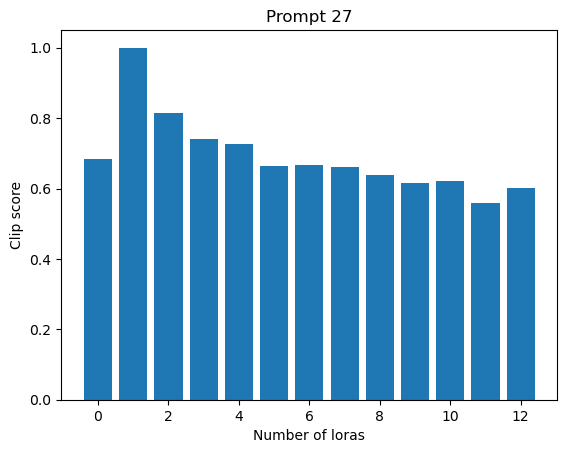

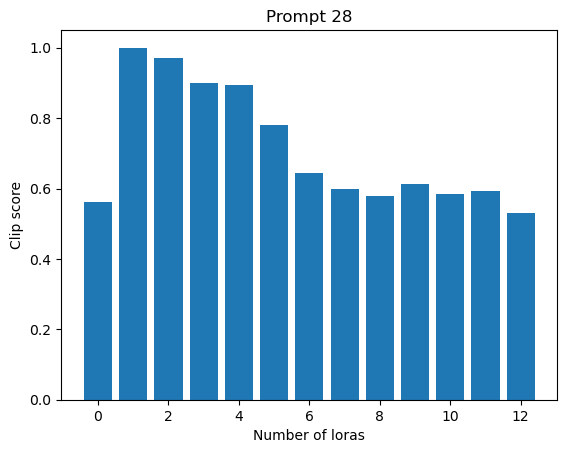

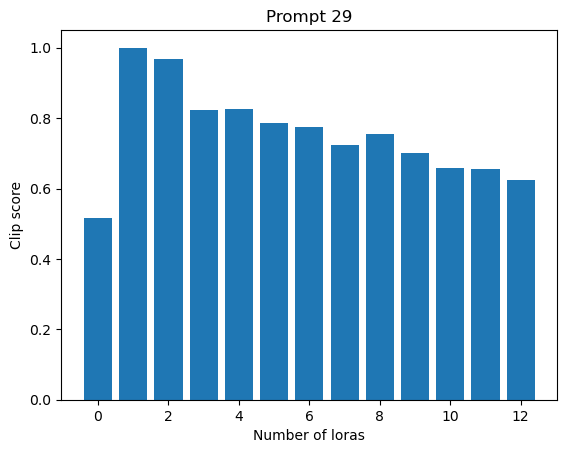

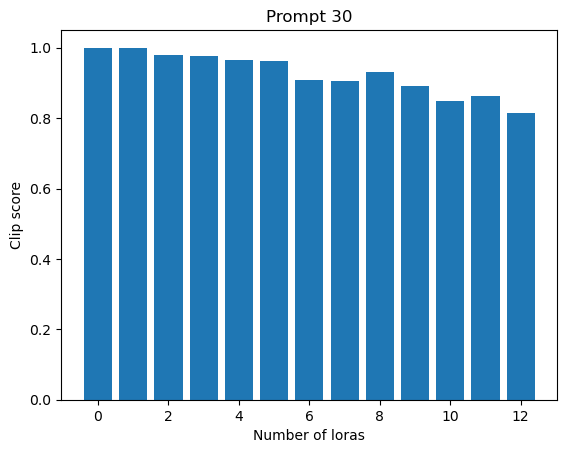

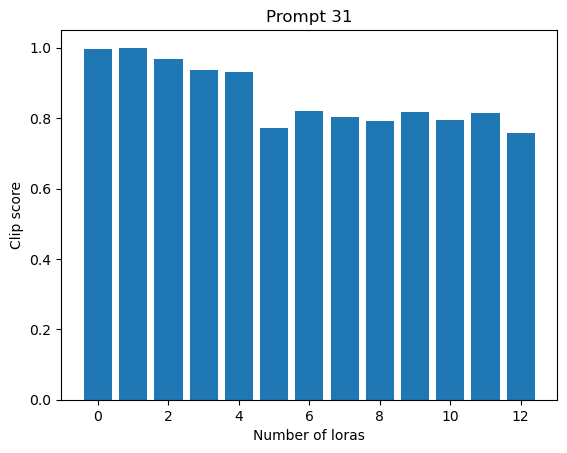

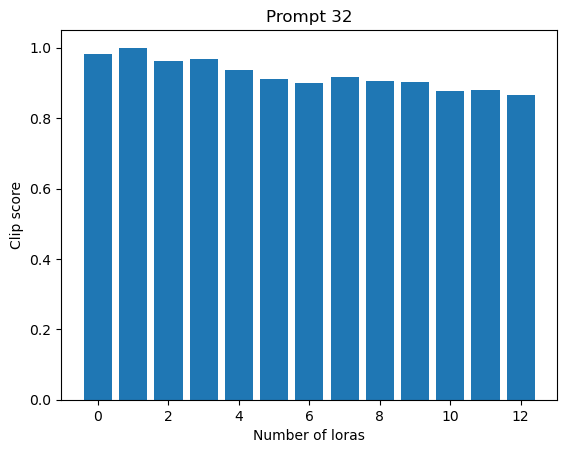

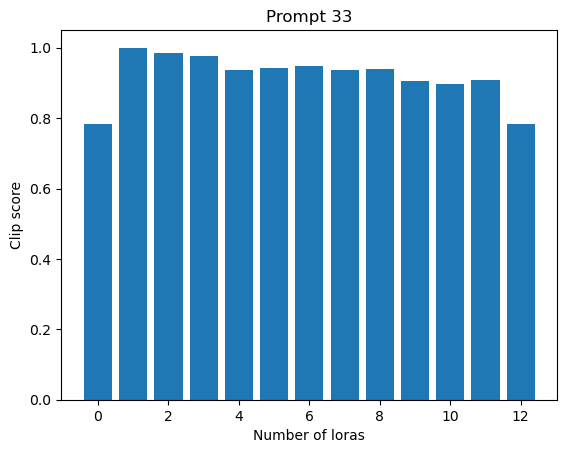

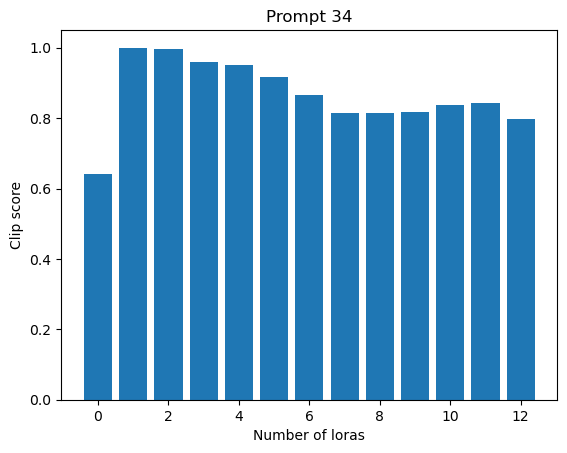

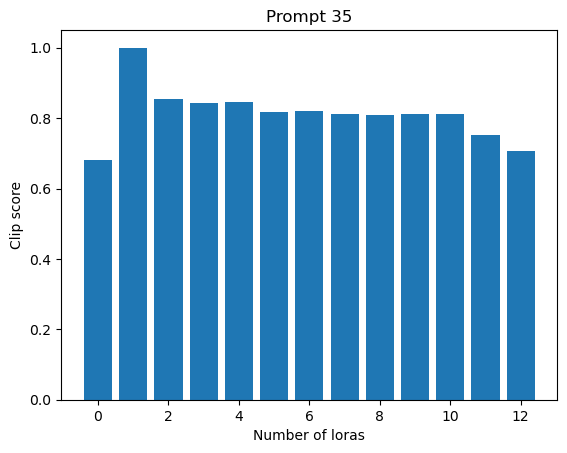

In [129]:
for prompt in range(scores.shape[0]):
    plt.bar(np.arange(len(scores[prompt])), scores[prompt])
    plt.ylabel('Clip score')
    plt.xlabel('Number of loras')
    plt.title(f'Prompt {prompt}')
    plt.show()
    plt.close()    

(0.5, 1.1)

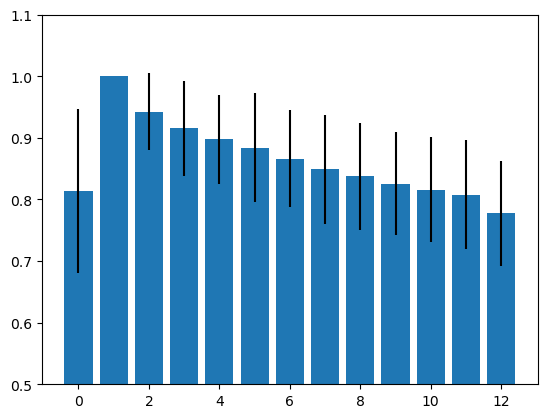

In [134]:
score_avg = np.mean(scores, axis = 0)
score_std = np.std(scores, axis = 0)
plt.bar(np.arange(len(score_avg)), score_avg, yerr = score_std)
plt.ylim(0.5,1.1)


(0.0, 1.1)

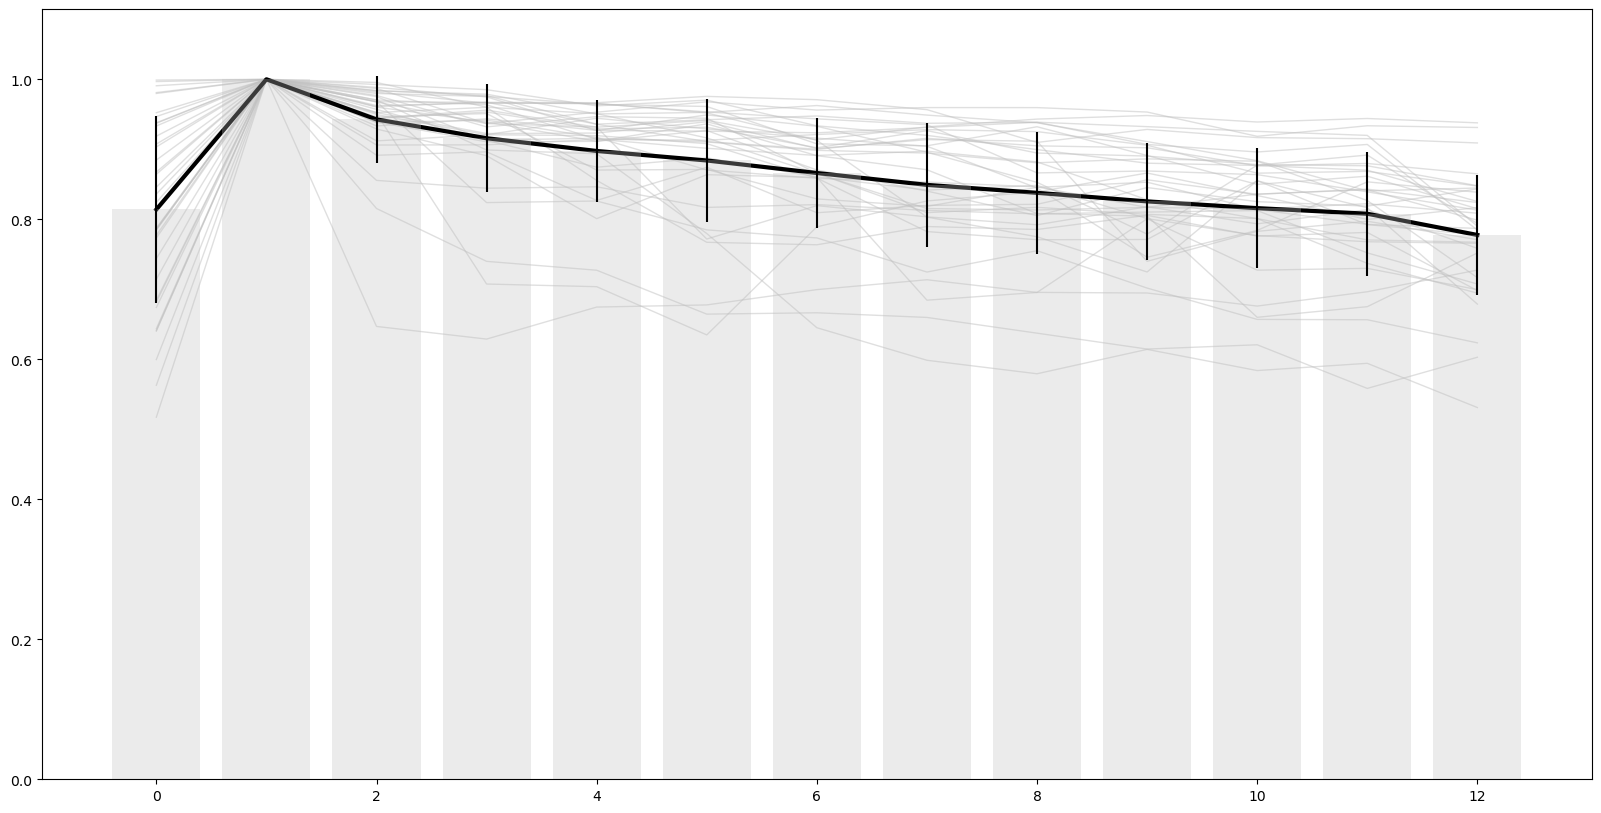

In [154]:
figsize = 

plt.figure(figsize = (20,10))
plt.plot(scores.T, c = 'silver', lw = 1, alpha = 0.5, zorder = 0)
plt.bar(np.arange(len(score_avg)), score_avg, yerr = score_std, color = 'silver', alpha = 0.3, zorder = 1)
plt.plot(score_avg, c = 'k', lw = 3, zorder = 0)

plt.ylim(0.,1.1)